# Analysis of Diversity in the Workplace

### What I did

1. Identify each employee's corresponding level (there're 6 levels in total)
2. Calculate how many people each employee manages (output a table with employee ids with the number of people managed)
3. Build a machine-learning model to predict the salary of each employee
4. Describe the main factors impacting employee salaries

### Sources

Datasets provided in the book - [A Collection of Data Science Takehome Challenges](https://datamasked.com/)

### Takeaways from the Analysis

__Are all employees being paid fair? Are there any bias?__

generally, the company treat its employee fairly. the difference among different sex and departments seems normal and fair enough.

the only bias I can see is that, the management level is likely to be overpaid. Higher the level, more likely to be overpaid.

__Suggestions to HR header__

I may suggest him/her considering lower down the salaries in high management level , which may be more fair to the workforce.
give higher salary to employees who are underpaid.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import scipy
from sklearn.metrics import pairwise_distances
import seaborn as sns
import sklearn
sns.set_style('darkgrid')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import chi2
import xgboost as xgb

def sh(df):
    print(df.shape)
    return df.head()

/Users/wanyihuang/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
comp = pd.read_csv('company_hierarchy.csv')

#assign 0 to boss_id if the employee doesn't have a boss (the CEO)
comp = comp.fillna(0)
comp.boss_id = comp.boss_id.astype(int)
print(comp.employee_id.nunique())
sh(comp)

10000
(10000, 3)


,employee_id,boss_id,dept
0,46456,175361,sales
1,104708,29733,HR
2,120853,41991,sales
3,142630,171266,HR
4,72711,198240,sales


In [3]:
#sanity check the null values in the dataset
comp.isnull().sum()

employee_id    0
boss_id        0
dept           0
dtype: int64

In [4]:
emp = pd.read_csv('employee.csv')
print(emp.employee_id.nunique())
sh(emp)

10000
(10000, 6)


,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


### 1. Identify each employee's corresponding level

__LOGIC (Use the top down method):__
1. Create a list of all levels
2. Write a loop to assign all levels to each employee_id based on their boss's level, starting from CEO to IC

The 6 levels for employees:
* Individual Contributors (IC) - they don't manage anyone
* Middle Managers (MM) - they are the direct bosses of IC
* Directors (D) - they are the direct bosses of MM
* VP - D direct bosses
* Executives (E) - VP direct bosses
* CEO - The direct boss of E.

In [5]:
levels = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
comp.loc[comp.dept == 'CEO', 'level'] = 'CEO' #start from  the ball rolling

for i in range(len(levels) - 1): #must use len(levels) - 1 because you want to start with boss level of CEO and then get the employee level using i+1
    boss_level = levels[i]  
    emp_level = levels[i + 1]
    boss_ids = comp.loc[comp.level == boss_level, 'employee_id'] #no need to transfer to list in order to use isin function
    comp.loc[comp.boss_id.isin(boss_ids), 'level'] = emp_level

In [6]:
comp.sample(10)

,employee_id,boss_id,dept,level
8704,26268,70547,marketing,IC
4309,147948,96664,marketing,IC
9889,43810,159098,engineering,IC
3606,123190,133420,sales,IC
8184,152022,92765,engineering,IC
4088,57810,52525,engineering,IC
457,40324,95169,sales,IC
511,12871,85426,HR,IC
1037,113555,104759,HR,IC
8655,30714,41808,HR,IC


In [7]:
comp.groupby('level').employee_id.nunique().reset_index()

,level,employee_id
0,CEO,1
1,D,160
2,E,4
3,IC,9000
4,MM,800
5,VP,35


### 2. Calculate how many people each employee manages

__LOGIC:__ <br>
Instead of using top down method, the bottom up method is used here: <br>
Start from the entry level and then sum the number of employees up based on direct management and indirect management.

In [8]:
levels = ['IC', 'MM', 'D', 'VP', 'E', 'CEO'] #bottom up, start from IC and then end with CEO
comp.loc[comp.level == 'IC', 'number'] = 0   #initiate the process with IC number = 0

for i in range(len(levels) - 1):
    emp_level = levels[i]
    boss_level = levels[i + 1]
    boss_ids = comp.loc[comp.level == boss_level, 'employee_id']
    for id in boss_ids:   #because this is not based on employee level assignment, it's based on each employe,so we loop through each single employee
        direct = len(comp[comp.boss_id == id]) #direct managed employees
        indirect = comp[comp.boss_id == id].number.sum() #indirect managed employees
        comp.loc[comp.employee_id == id, 'number'] = direct + indirect  #the final number should be direct + indirect

In [9]:
comp.sample(10)

,employee_id,boss_id,dept,level,number
6159,142890,87330,engineering,IC,0.0
4308,6371,16073,marketing,IC,0.0
9353,86379,165853,engineering,IC,0.0
5088,134812,5889,HR,IC,0.0
9016,70809,15768,HR,IC,0.0
8088,108912,79237,marketing,IC,0.0
3671,138823,124994,HR,D,116.0
8346,60753,47748,HR,IC,0.0
5100,141763,132192,HR,IC,0.0
5326,21987,159098,engineering,IC,0.0


In [10]:
comp.groupby('level').number.mean()

level
CEO    9999.000000
D        61.250000
E      2498.750000
IC        0.000000
MM       11.250000
VP      284.571429
Name: number, dtype: float64

### 3. Build a machine-learning model to predict the salary of each employee

__LOGIC:__ <br>
1. Visualization (exploratory analysis to detect patterns), segment the employees properly to observe the possible difference
2. Feature Engineering:
    - remove the unnecessary columns 
    - transform some columns into numbers (one-hot encoding) - the order matters
    - log transformation for highly right skewed data
    - remove the outliers (especially for income data)
3. Split the df to train and test dataset for model training 
4. Evaluate the model by calculating the RMSE

In [11]:
df = comp.merge(emp, how = 'left', on = 'employee_id')
df["salary"] /= 1000
sh(df)

(10000, 10)


,employee_id,boss_id,dept,level,number,signing_bonus,salary,degree_level,sex,yrs_experience
0,46456,175361,sales,IC,0.0,0,213.0,Bachelor,M,5
1,104708,29733,HR,IC,0.0,0,79.0,Bachelor,F,3
2,120853,41991,sales,IC,0.0,0,199.0,High_School,M,5
3,142630,171266,HR,MM,16.0,0,143.0,PhD,F,13
4,72711,198240,sales,IC,0.0,0,235.0,Master,M,1


#### 3.1 Data Visualization

/Users/wanyihuang/anaconda/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/wanyihuang/anaconda/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/wanyihuang/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/wanyihuang/anaconda/lib/python3.6/site-packages/mat

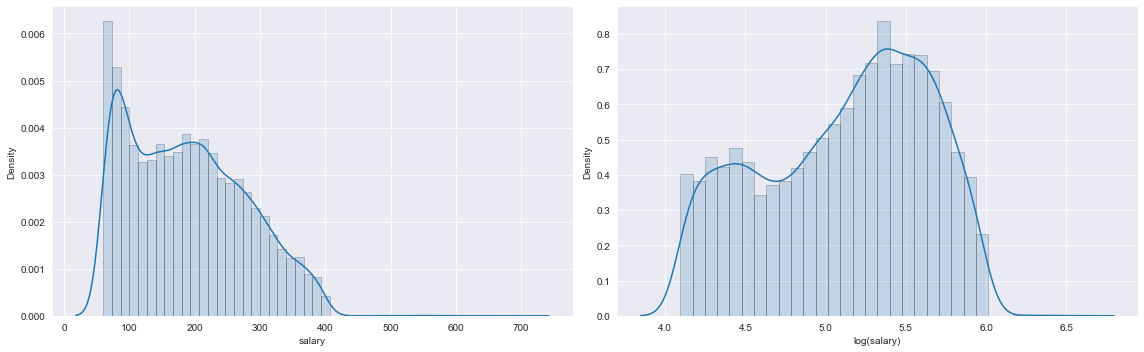

In [12]:
# Distribution of salary
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.distplot(df['salary'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(df['salary']), ax=ax[1], hist_kws=hist_kws)
ax[1].set_xlabel('log(salary)')
plt.tight_layout()
plt.show()

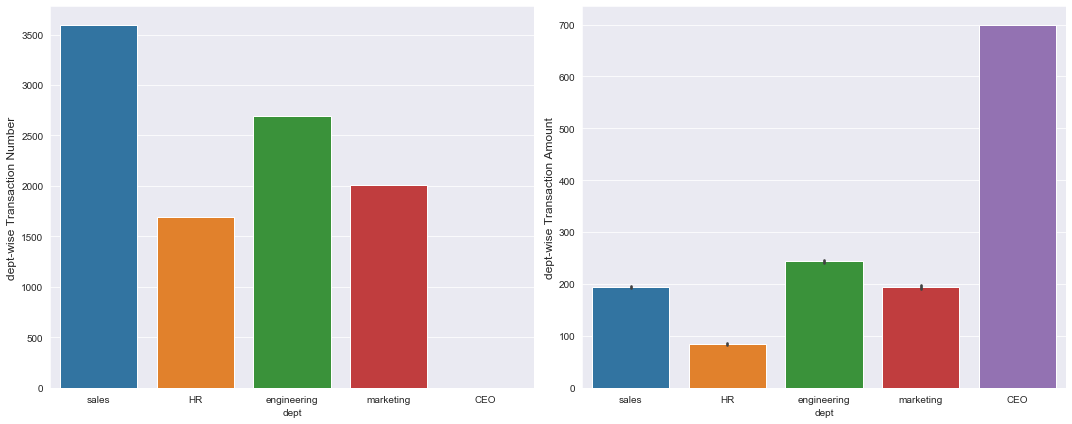

In [13]:
# dept
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(x='dept', data=df, ax=ax[0])
ax[0].set_ylabel('dept-wise Transaction Number', fontsize=12)

sns.barplot(x='dept', y='salary', data=df, ax=ax[1])
ax[1].set_ylabel('dept-wise Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

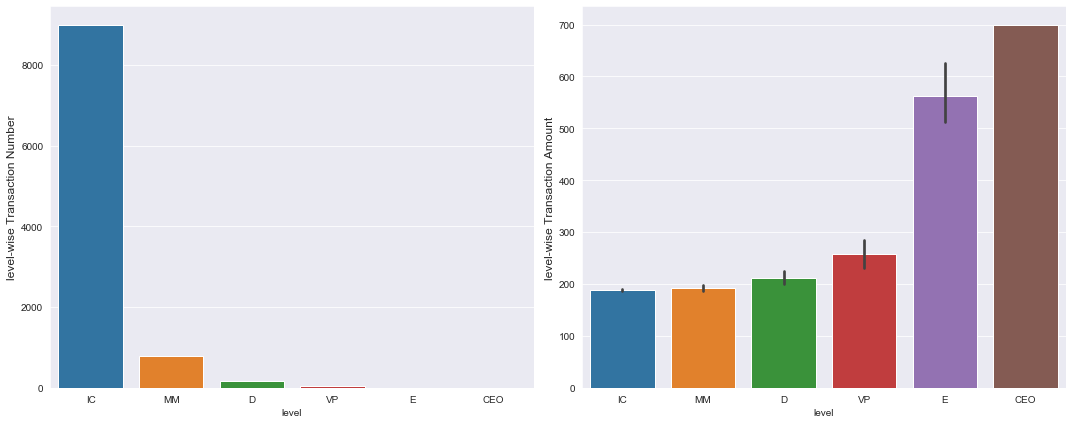

In [14]:
# level
orders = ['IC', 'MM', 'D', 'VP', 'E', 'CEO']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(x='level', data=df, ax=ax[0], order=orders)
ax[0].set_ylabel('level-wise Transaction Number', fontsize=12)

sns.barplot(x='level', y='salary', data=df, ax=ax[1], order=orders)
ax[1].set_ylabel('level-wise Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

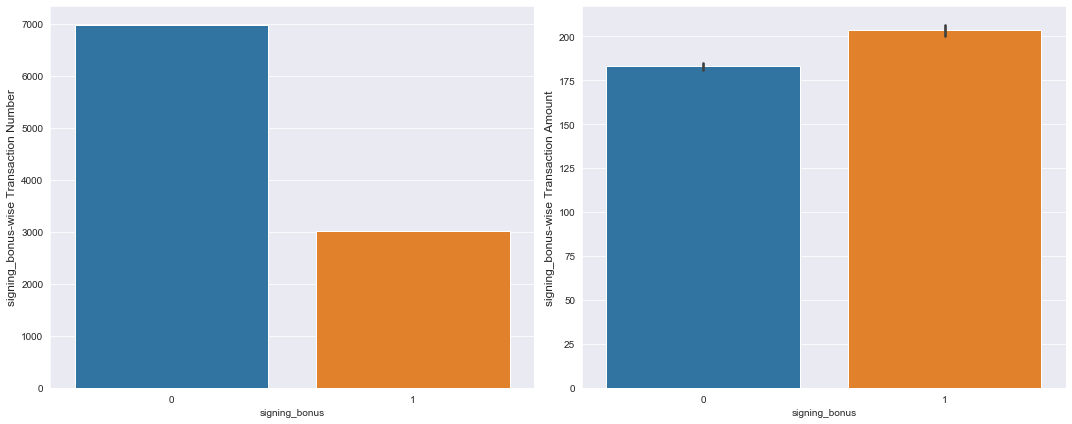

In [15]:
# signing_bonus
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(x='signing_bonus', data=df, ax=ax[0])
ax[0].set_ylabel('signing_bonus-wise Transaction Number', fontsize=12)

sns.barplot(x='signing_bonus', y='salary', data=df, ax=ax[1])
ax[1].set_ylabel('signing_bonus-wise Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

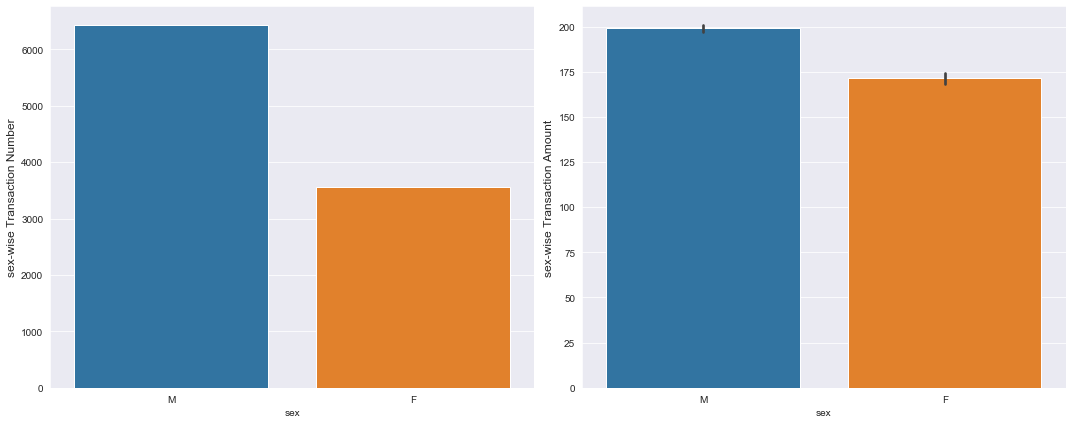

In [16]:
# sex
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(x='sex', data=df, ax=ax[0])
ax[0].set_ylabel('sex-wise Transaction Number', fontsize=12)

sns.barplot(x='sex', y='salary', data=df, ax=ax[1])
ax[1].set_ylabel('sex-wise Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

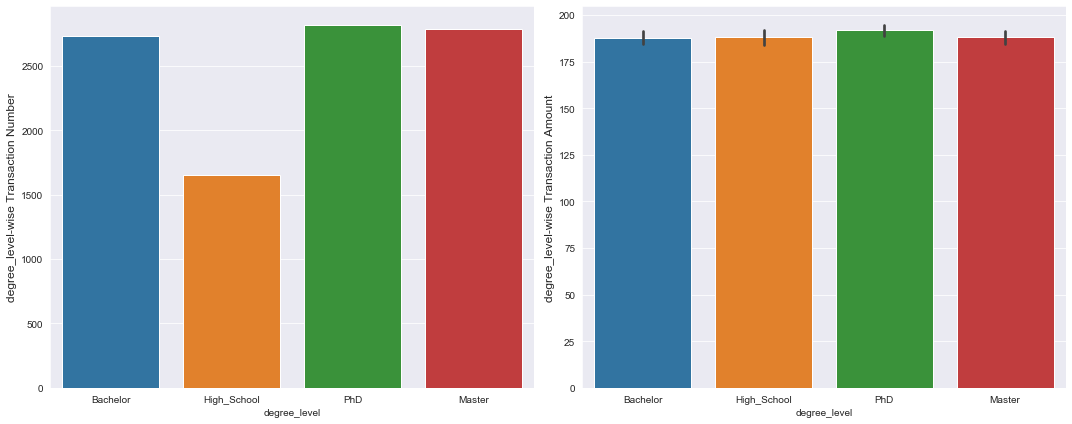

In [17]:
# degree_level
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(x='degree_level', data=df, ax=ax[0])
ax[0].set_ylabel('degree_level-wise Transaction Number', fontsize=12)

sns.barplot(x='degree_level', y='salary', data=df, ax=ax[1])
ax[1].set_ylabel('degree_level-wise Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

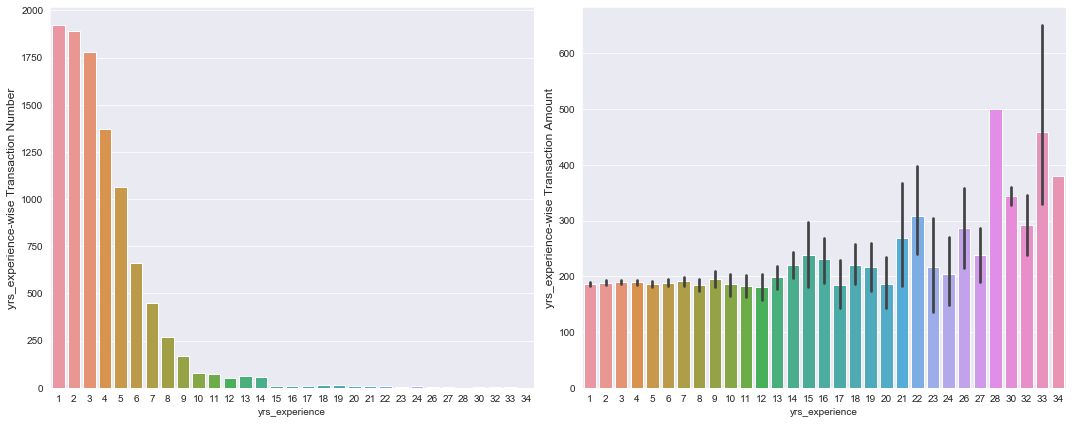

In [18]:
# yrs_experience
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.countplot(x='yrs_experience', data=df, ax=ax[0])
ax[0].set_ylabel('yrs_experience-wise Transaction Number', fontsize=12)

sns.barplot(x='yrs_experience', y='salary', data=df, ax=ax[1])
ax[1].set_ylabel('yrs_experience-wise Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

#### 3.2 Feature Engineering

In [19]:
X = df.copy()

X["is_male"] = (X.sex == "M").astype(int)
del X["sex"]
del X['boss_id']#assuming boss_id won't affect salary

# transform 'level' into numbers
# !!! ORDER matters
index2level = ['IC','MM',"D","VP","E","CEO"]
level2index = {l:index for index,l in enumerate(index2level)}
X['level'] = X.level.map(level2index)

# transform 'educational degree' into numbers
# !!! ORDER matters
index2degree = ['High_School','Bachelor','Master','PhD']
degree2index = {d:index for index,d in enumerate(index2degree)}
X['degree'] = X.degree_level.map(degree2index)
del X['degree_level']

# OHE department
X = pd.get_dummies(X)
del X['dept_CEO']

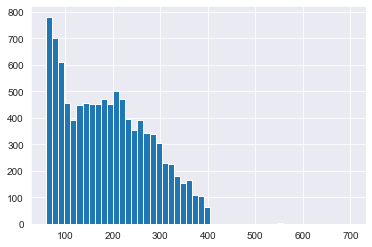

In [20]:
X.salary.hist(bins=50)

The histogram shows that, salary's distribution is highly skewed, which increased the difficulty on regression. So I need to apply the log transformation on the target value.

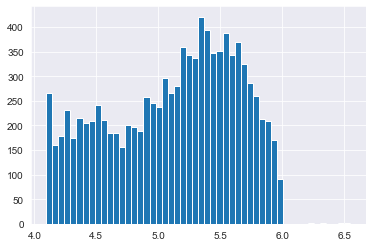

In [21]:
X['salary'] = np.log(X.salary)
X.salary.hist(bins=50)

In [22]:
X = X.set_index('employee_id')

X.head()# glance the data

,level,number,signing_bonus,salary,yrs_experience,is_male,degree,dept_HR,dept_engineering,dept_marketing,dept_sales
employee_id,,,,,,,,,,,
46456,0,0.0,0,5.361292,5,1,1,0,0,0,1
104708,0,0.0,0,4.369448,3,0,1,1,0,0,0
120853,0,0.0,0,5.293305,5,1,0,0,0,0,1
142630,1,16.0,0,4.962845,13,0,3,1,0,0,0
72711,0,0.0,0,5.459586,1,1,2,0,0,0,1


In [23]:
X.groupby('level')['salary'].agg(['count','mean'])

,count,mean
level,,
0,9000,5.112835
1,800,5.136089
2,160,5.256181
3,35,5.496709
4,4,6.327854
5,1,6.551080


From the table above, we can see there is only one CEO, and his salary is much higher than any other employees in this company.

When splitting the data into training/test sets, no matter which set contains CEO, his high salary will impact significantly the training or evaluation. Therefore, CEO data is an outlier and has to be removed from the dataset.

In [24]:
#Remove Outliers:
X = X.loc[X.level != 5,:]

#### 3.3 Create the model based on train and test dataset

In [25]:
y = X['salary']
del X['salary']

In [26]:
seed = 999
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=seed)

In [27]:
Xtrain.level.value_counts()

0    6306
1     554
2     108
3      27
4       4
Name: level, dtype: int64

In [28]:
Xtest.level.value_counts()

0    2694
1     246
2      52
3       8
Name: level, dtype: int64

In [29]:
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

In [30]:
params = {}
params['silent'] = 1
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
# params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[11:05:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds, num_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:05:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-

In [31]:
n_best_trees = cv_results.shape[0]
n_best_trees

52

In [32]:
# re-train on all the data
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[11:05:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[11:05:41] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds, num_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:4.18590
[1]	train-rmse:3.77087
[2]	train-rmse:3.39827
[3]	train-rmse:3.06284
[4]	train-rmse:2.76207
[5]	train-rmse:2.49109
[6]	train-rmse:2.24856
[7]	train-rmse:2.03050
[8]	train-rmse:1.83545
[9]	train-rmse:1.66047
[10]	train-rmse:1.50405
[11]	train-rmse:1.36431
[12]	train-rmse:1.24021


#### 3.4 Evaluate the model results

In [33]:
ytest_pred = gbt.predict(test_matrix, ntree_limit=n_best_trees)
np.sqrt(mean_squared_error(ytest,ytest_pred))

0.39662229125979864

The training RMSE is 0.38, and test set has RMSE 0.39, the difference isn't very high.

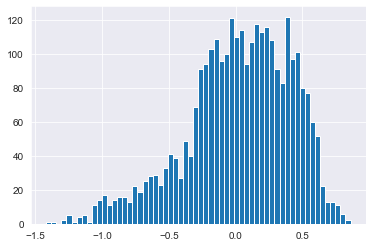

In [34]:
# check residual's distribution
(ytest - ytest_pred).hist(bins=60)

The histogram shows that the residuals' distribution is nearly normal, although a little skewed. Hence, the trained model is acceptable.

In [35]:
gbt.save_model('gbt.model')

### 4. Describe the main factors impacting employee salaries

__LOGIC:__ <br>
- Use xgboost importance to retrieve the highly important features influencing employees' salary
- Use the xgboost model to predict each employee's predicted salary based on their features and then compare the predicted salary with their actual salary to see if they have been overpaid or not

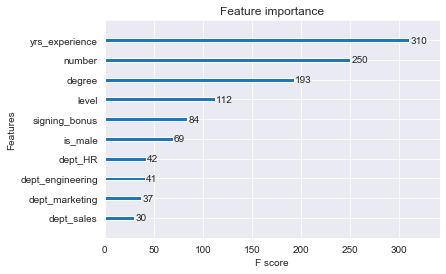

In [36]:
xgb.plot_importance(gbt)

From above plot of feature importance, we can see the main factors impacting salaries includes:

- "years of experience". this is fair, more experienced deserve high salary
- 'n_subordinates'. #subordinates has some relationship with level.  Employees are more likely to get higher salary when he/she has more subordinates

In [37]:
# predict on all data (except CEO) and calculate the bias
whole_matrix = xgb.DMatrix(X)
ypred = gbt.predict(whole_matrix)

# since our prediction is log(salary), so we need to exp it to get the original salary (unit: k)
predresult = pd.DataFrame({'ytrue': np.exp(y),'ypred': np.exp(ypred)})

# if bias >0, means, that employee is over paid
# otherwise, bias<0, means that employee is under paid
predresult['bias'] = predresult.ytrue - predresult.ypred

In [38]:
sh(predresult)

(9999, 3)


,ytrue,ypred,bias
employee_id,,,
46456,213.0,177.610519,35.389481
104708,79.0,80.504051,-1.504051
120853,199.0,177.410675,21.589325
142630,143.0,99.492989,43.507011
72711,235.0,179.232178,55.767822


In [39]:
df1 = df.set_index('employee_id')
sh(df1)

(10000, 9)


,boss_id,dept,level,number,signing_bonus,salary,degree_level,sex,yrs_experience
employee_id,,,,,,,,,
46456,175361,sales,IC,0.0,0,213.0,Bachelor,M,5
104708,29733,HR,IC,0.0,0,79.0,Bachelor,F,3
120853,41991,sales,IC,0.0,0,199.0,High_School,M,5
142630,171266,HR,MM,16.0,0,143.0,PhD,F,13
72711,198240,sales,IC,0.0,0,235.0,Master,M,1


In [40]:
# join with employee's features
predresult = predresult.join(df1)
predresult.head() # glance

,ytrue,ypred,bias,boss_id,dept,level,number,signing_bonus,salary,degree_level,sex,yrs_experience
employee_id,,,,,,,,,,,,
46456,213.0,177.610519,35.389481,175361,sales,IC,0.0,0,213.0,Bachelor,M,5
104708,79.0,80.504051,-1.504051,29733,HR,IC,0.0,0,79.0,Bachelor,F,3
120853,199.0,177.410675,21.589325,41991,sales,IC,0.0,0,199.0,High_School,M,5
142630,143.0,99.492989,43.507011,171266,HR,MM,16.0,0,143.0,PhD,F,13
72711,235.0,179.232178,55.767822,198240,sales,IC,0.0,0,235.0,Master,M,1


In [41]:
del predresult['ytrue'] # redundant with salary

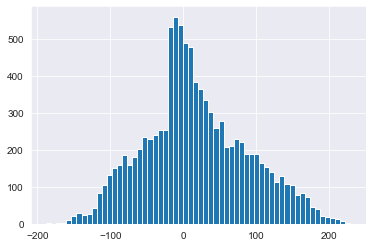

In [42]:
predresult.bias.hist(bins=60)

Bias is almost normally distributed.

Text(0, 0.5, 'bias')

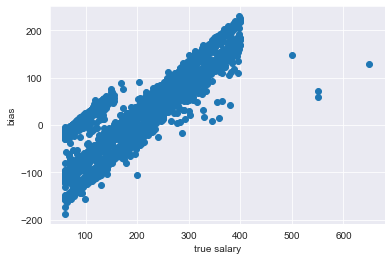

In [43]:
plt.scatter(predresult.salary,predresult.bias)
plt.xlabel("true salary")
plt.ylabel("bias")

The scatterplot shows that, employee with high salary are more likely to be overpaid.

In [44]:
def chisquare_test_on_bias():
    X = predresult.copy()
    del X['ypred']
    del X['salary']
    del X['boss_id']

    X['degree_level'] = X.degree_level.map(degree2index)
    X['level'] = X.level.map(level2index)

    X['is_male'] = (X.sex == 'M').astype(int)
    del X['sex']

    dept_lb_encoder = LabelEncoder()
    X['dept'] = dept_lb_encoder.fit_transform(X.dept)
    
    y = (X.bias > 0)
    del X['bias']
    
    scores,pvalues = chi2(X,y)
    return pd.DataFrame({'score': scores, 'pvalue': pvalues},index = X.columns).sort_values(by='pvalue')

In [45]:
chisquare_test_on_bias()

,score,pvalue
number,4402.165967,0.000000
dept,8.006038,0.004662
yrs_experience,7.801773,0.005219
level,4.487657,0.034140
is_male,0.990816,0.319543
signing_bonus,0.367378,0.544437
degree_level,0.346021,0.556375


Test result shows that: n_subordinates, department, level, yrs_experience are four factors impacting whether the employee is overpaid or underpaid.

Text(0, 0.5, 'bias')

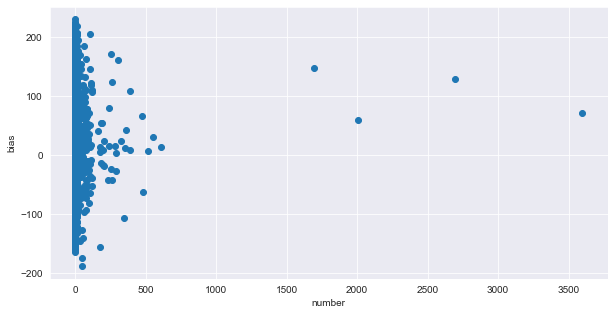

In [46]:
plt.figure(figsize=(10,5))
plt.scatter(predresult.number,predresult.bias)
plt.xlabel("number")
plt.ylabel("bias")

The scatterplot shows that, with more subordinates (i.e., higher level), there're more positive bias, meaning the person is more likely to be overpaid.